In [1]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from scipy import signal
import librosa
import IPython.display

Text(0.5, 1.0, 'Frequency response of pre-emphasis filter H(z) = 1 - p z^{-1} (p=0.97)')

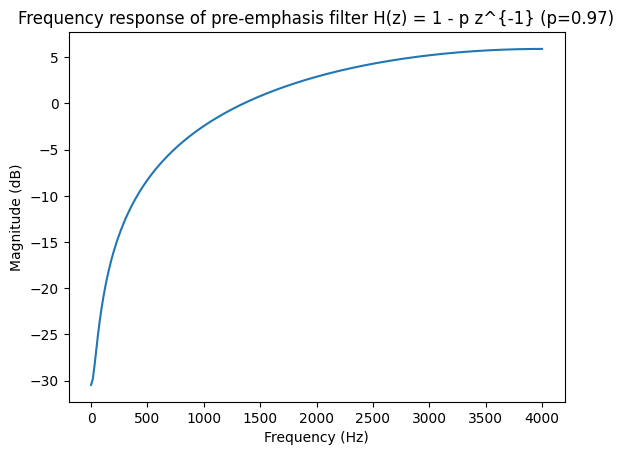

In [2]:
# サンプリング周波数 [Hz]
# ここでは 8 kHz の音声を想定している
sr = 8000

# FFT のポイント数
# rFFT の結果は 0〜ナイキスト（sr/2）までの nFFT/2+1 点になる
nFFT = 512

# 周波数軸を生成
# np.fft.rfftfreq(nFFT, 1/sr) は rFFT の各ビンに対応する周波数 [Hz] を返す
f = np.fft.rfftfreq(nFFT, 1 / sr)

# プリエンファシス係数 p
# 1 サンプル前との差分をとる 1 次の FIR フィルタ
#   H(z) = 1 - p z^{-1}
# を使うとき、p ≒ 0.95〜0.97 がよく使われる。
# 高周波側を持ち上げて、音声のスペクトル包絡（フォルマント）解析をしやすくする目的がある。
p = 0.97

# フィルタのインパルス応答（FIR 係数）を長さ 2 の配列で表現
# [1, -p] は
#   y[n] = x[n] - p x[n-1]
# という 1 次差分型の高域強調フィルタに対応する。
h = [1, -p]

# インパルス応答 h の周波数応答を rFFT で計算する
#   S[k] = Σ_n h[n] e^{-j 2π k n / nFFT}
# ここでは nFFT 点で評価しているので周波数分解能は sr/nFFT [Hz] になる。
S = np.fft.rfft(h, nFFT)

# 振幅スペクトルの大きさ |S(f)| を dB スケールでプロット
# 20*log10(|S|) とすることで、振幅の比をデシベル表現に変換している
# このフィルタは高域になるほどゲインが大きくなる高域強調（ハイパスに近い）特性を持つ。
plt.plot(f, 20 * np.log10(np.abs(S)))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title("Frequency response of pre-emphasis filter H(z) = 1 - p z^{-1} (p=0.97)")

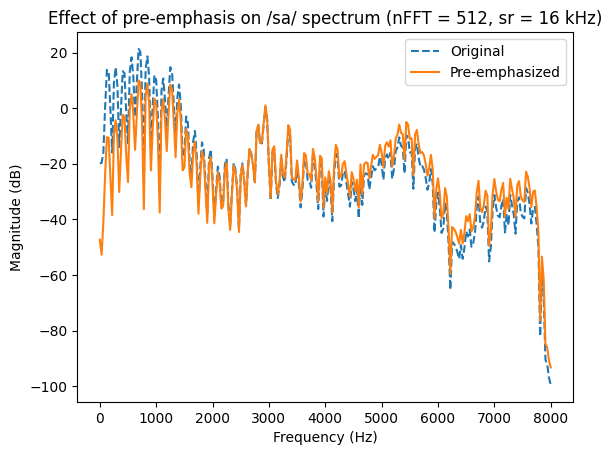

In [4]:
# 以前の図を閉じて、今回のプロットだけが表示されるようにする
plt.close()

# -------------------------------------------------------
# 1. /sa/ 音声の読み込みと解析フレームの設定
# -------------------------------------------------------
# 'sa48k.wav' をサンプリング周波数 16 kHz にリサンプリングして読み込む
#   ySa : 音声波形（1 次元 numpy 配列）
#   sr  : 実際に読み込まれたサンプリングレート（ここでは 16000 Hz になる）
ySa, sr = librosa.load("sa48k.wav", sr=16000)

# FFT サイズ（＝解析フレーム長）を 512 サンプルに設定
#   512 サンプル / 16000 Hz ≒ 32 ms の時間窓
nFFT = 512

# -------------------------------------------------------
# 2. プリエンファシス前のスペクトル（元の波形）
# -------------------------------------------------------
# 解析フレームとして、サンプルインデックス 7500 から 512 サンプル分を取り出す
#   7500 / 16000 ≒ 0.47 s 以降の約 32 ms 区間を見ている
frame = ySa[7500 + np.arange(nFFT)]

# ハニング窓を掛けてから rFFT を取る
#   ・窓を掛ける → フレーム両端で滑らかに 0 に近づけ、スペクトルリークを抑える
#   ・np.fft.rfft → 実信号に対する片側スペクトル（0〜ナイキスト）を計算
SSa = np.fft.rfft(frame * np.hanning(nFFT))

# -------------------------------------------------------
# 3. プリエンファシス（高域強調フィルタ）の適用
# -------------------------------------------------------
# ySaEmphasis : プリエンファシス後の波形
#   フィルタ H(z) = 1 - p z^{-1} を適用している
#   y[n] = x[n] - p x[n-1]
#   p は前セルで定義したプリエンファシス係数（例: p = 0.97）を想定
ySaEmphasis = signal.lfilter([1, -p], 1, ySa)

# 同じ位置（7500 サンプル目付近）から、プリエンファシス後のフレームを取り出す
frame_emph = ySaEmphasis[7500 + np.arange(nFFT)]

# ハニング窓を掛けて rFFT を計算
SSaEmphasis = np.fft.rfft(frame_emph * np.hanning(nFFT))

# -------------------------------------------------------
# 4. 周波数軸の生成と、振幅スペクトルの dB プロット
# -------------------------------------------------------
# rFFT の各ビンに対応する周波数 [Hz] を計算
#   Δf = sr / nFFT で一定間隔の周波数グリッドになる
frequency = np.fft.rfftfreq(nFFT, 1 / sr)

# 元のスペクトル（プリエンファシスなし）の振幅特性を dB で描画
#   20 log10 |S(f)| で振幅の比をデシベル表現に変換
#   '--' で破線にして、あとから描くプリエンファシス後と区別
plt.plot(frequency, 20 * np.log10(np.abs(SSa)), "--", label="Original")

# プリエンファシス後のスペクトルを重ねて描画
#   高周波数側の成分が持ち上がり、スペクトル包絡がフラットに近づくことが期待される
plt.plot(frequency, 20 * np.log10(np.abs(SSaEmphasis)), label="Pre-emphasized")

# 軸ラベルや凡例などを整える
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title("Effect of pre-emphasis on /sa/ spectrum (nFFT = 512, sr = 16 kHz)")
plt.legend()

# この図により、
#   ・元の音声スペクトルでは高域が弱く、低域にエネルギーが集中している
#   ・プリエンファシス後は高域が相対的に持ち上がり、スペクトル包絡がなだらかになる
# といった「高域強調フィルタの目的と効果」を視覚的に確認できる。